In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import glob
import numpy as np
import optics_rig as orig
from scipy.interpolate import interp1d
from scipy import signal as signal
from scipy.stats import gamma, burr12

from iteration_utilities import flatten

import os
import glob
from scipy import optimize
import copy
import dill

import colorcet as cc

from scipy.integrate import trapz

In [2]:
pd.options.display.max_columns = None # this is to see all columns of pandas dataframes

In [3]:
DDIL = '/Users/gdal/Dropbox/Project/PICCOLO/Cruise/Data/Optics_rig/Processed/'
DPLOTS = '/Users/gdal/Dropbox/Project/PICCOLO/Cruise/Data/Optics_rig/Plots/'
DWAP_EX = '/Users/gdal/Dropbox/Project/PICCOLO/Cruise/Data/Optics_rig/WAP_Extracted/'


## Check typical descent speed 

In [4]:
fn = DDIL + '20240210.dil'
dil = orig.load_dill(fn)

In [5]:
dil.keys()

dict_keys(['__name__', '__doc__', '__package__', '__loader__', '__spec__', '__file__', '__cached__', '__builtins__', 'pd', 'plt', 'glob', 'np', 'interp1d', 'flatten', 'dill', 'os', 'rd_FCSub', 'rd_CTD', 'rd_SC6', 'rd_Tridente', 'rd_BB3', 'rd_ACS', 'get_iFilt_iBulk', 'int_ctd', 'interp_acs_remove_step', 'interp_acs_wv', 'interp_acs_press', 'rd_dac2dTS', 'f_Ts', 'load_dill', 'plot_spikes', 'CHL_MAX', 'DIN', 'DPLOTS', 'DPROC', 'DWAP_EX', 'FLU_MAX', 'MAX_DEPTH', 'PORTS', 'YMAX', 'a_wv', 'a_wv_str', 'acs', 'acs_wv', 'bb3', 'bin_medians', 'c', 'c_wv', 'c_wv_str', 'chl_beta', 'ctd', 'data', 'fcsub', 'fn_ACS', 'fn_BB3', 'fn_CTD', 'fn_FCSub', 'fn_RBR', 'fn_SC6', 'fnout', 'fns', 'i2keep', 'i650', 'i676', 'i750', 'iBulk_FCSub', 'iBulk_acs', 'iBulk_bb3', 'iBulk_ctd', 'iBulk_rbr', 'iBulk_sc6', 'iFilt_FCSub', 'iFilt_acs', 'iFilt_bb3', 'iFilt_ctd', 'iFilt_rbr', 'iFilt_sc6', 'idip', 'ipres', 'istart', 'msecBulk_FCSub_minmax', 'msecFilt_FCSub_minmax', 'pres', 'pres_bins', 'rbr', 'sc6', 'sc6_channels', 

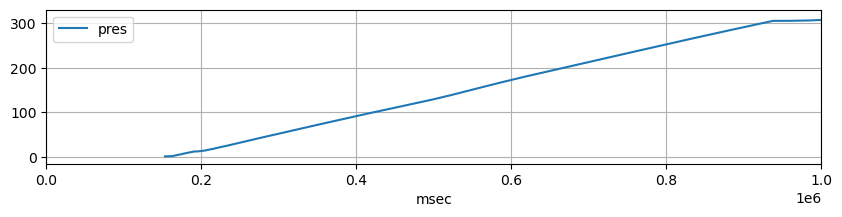

In [6]:
dil['ctd'].plot(y='pres', xlim=[0, 1e6], figsize=[10,2])
plt.grid()

In [7]:
# compute descent speed in cm/s
i100 = np.where(dil['ctd']['pres'] >= 100)[0][0]
i300 = np.where(dil['ctd']['pres'] >= 300)[0][0]
print(str(np.round((dil['ctd']['pres'].values[i300]-dil['ctd']['pres'].values[i100])*100/((dil['ctd'].index[i300]-dil['ctd'].index[i100])/1000),2)) + " cm/s")

39.91 cm/s


In [8]:
fns = np.sort(glob.glob(DDIL + '*.dil'))

In [9]:
fn = fns[10]
fn

'/Users/gdal/Dropbox/Project/PICCOLO/Cruise/Data/Optics_rig/Processed/20240208.dil'

## Read dil file

In [10]:
dil = orig.load_dill(fn)

## Create RBR dataframe with re-zeroed index

In [11]:
rbr = dil['rbr']
rbr['msec_rbr'] = rbr['msec_rbr'].values - rbr['msec_rbr'].values[0]
rbr.set_index('msec_rbr', inplace=True)
rbr.describe()

,msec_orig,BB700,chl_fluo,ch3,temp,cond,pres,uknown
count,6.390500e+04,63905.000000,63905.000000,63905.000000,63905.000000,63905.000000,63905.000000,63905.000000
mean,1.107342e+06,0.004815,0.006310,0.262818,0.005554,2.874942,185.265924,0.000485
std,5.729379e+05,0.002175,0.006765,0.044798,0.942642,0.106522,104.283125,0.000064
min,1.152500e+05,0.003468,-0.002018,0.135175,-1.618400,2.662990,0.171000,0.000300
25%,6.110000e+05,0.003770,0.001839,0.234271,-1.022702,2.780725,93.517265,0.000438
50%,1.107250e+06,0.004000,0.003189,0.281635,0.602400,2.938829,190.742448,0.000500
75%,1.603500e+06,0.005601,0.009024,0.295528,0.754925,2.959706,286.204500,0.000513
max,2.099750e+06,0.177735,0.094814,0.489733,0.790900,2.960610,322.041000,0.000700


<Axes: xlabel='msec_rbr'>

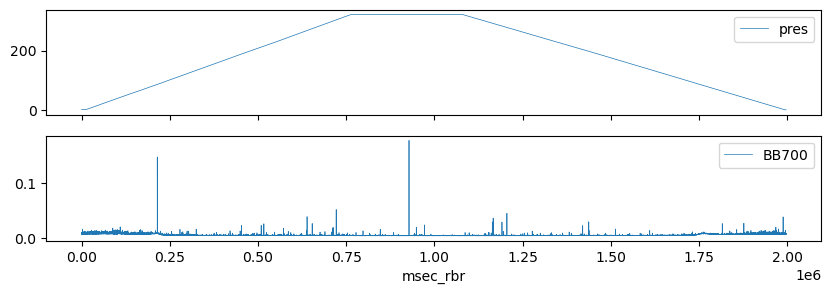

In [12]:
fig, ax = plt.subplots(2,1, figsize=[10,3], sharex=True)
rbr.plot(y='pres', lw=0.5, ax=ax[0])
rbr.plot(y='BB700', lw=0.5, ax=ax[1])

In [13]:
rbr['BB700'].count()

63905

## Extract descending profile

In [14]:
imaxpres = np.where( rbr['pres'] >= rbr['pres'].max()-5 )[0][0]
iminpres = np.where( rbr['pres'] >= 5 )[0][0]

rbr = rbr.iloc[iminpres:imaxpres]

## Extract random part of profile with given time length (dt)

### Define bin size in seconds

In [15]:
dt = 40 # [sec]  Note: for a typical ascent rate of 10 cm/s, this is dt*10 cm or dt/10 m

### Estimate profile sampling rate in 1/seconds

In [16]:
sampling_rate = np.round(1/np.nanmedian(np.diff(rbr.index)) * 1000)  # [sample/sec]
sampling_rate

32.0

In [17]:
# extract random part of profile

max_index = rbr['BB700'].count() - dt*sampling_rate
i_low = np.random.randint(0, high=max_index , size=None, dtype=int)
i_high = i_low + dt*sampling_rate

i_smpl = np.arange(i_low, i_high, 1)
N = len(i_smpl)
N

1280

In [18]:
rbr_smpl = rbr['BB700'].iloc[i_smpl]

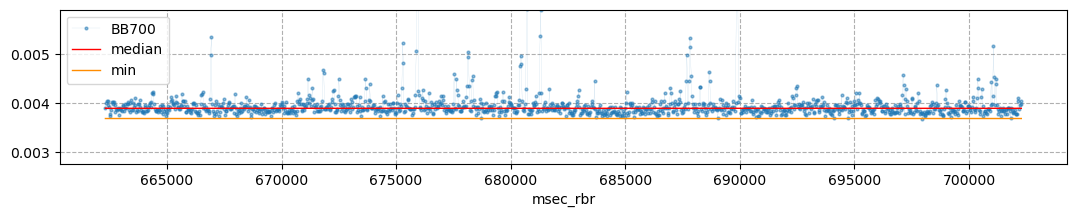

In [19]:
fig, ax = plt.subplots()

# original data
rbr_smpl.plot(lw=0.1, marker='.', markersize=4, ylim=[rbr_smpl.min() - rbr_smpl.min()/4, np.percentile(rbr_smpl, 99.5)], figsize=[13,2], ax=ax, alpha=0.5)

# median value
ax.plot(rbr_smpl.index, np.ones(rbr_smpl.index.size) * np.median(rbr_smpl), 'r-', lw=1, label='median')

# min value
ax.plot(rbr_smpl.index, np.ones(rbr_smpl.index.size) * np.min(rbr_smpl), '-', c='darkorange', lw=1, label='min')

ax.legend()

ax.grid(ls='--')
# ax.set_yscale('log')

In [20]:
# fig, ax = plt.subplots(1,1, figsize=[13,3])
# bins = 100

# plt.hist(np.log10(rbr_smpl), bins=bins, cumulative=False);
# # ax.set_xscale('log')


# Extract spikes and log-transform them

## DOUBT
To compute the spikes, if we subtract the median value of the time bin, then we will have negative values in the resulting spikes which will prevent us from log transfomring the spikes.

Do we just add a constant value (that must be higher than the minimum of `rbr_smpl - np.median(rbr_smpl)` ?

In [21]:
# constant = 0.01
# rbr_spikes = rbr_smpl - np.median(rbr_smpl) + constant
# rbr_log_spikes = np.log10(rbr_spikes)


# fig, ax = plt.subplots()

# rbr_log_spikes.plot(lw=0.1, marker='.', markersize=2, figsize=[13,2], ax=ax)
# ax.grid(ls='--')


I don't think so, because  this would just shift the whole log-transformed dataset by a given amount, but would not isolate the spikes.

To isolate the spikes we really need to drop some of the data. 

It's easy to drop those below the median, but how do we remove those above the median?

IDEA: perhaps we could estimate the "half of the noise of the sensor" by computing the difference between `median(BB700)` and `min(BB700)` value and then removing this half noise from the the data above the median.

/Users/gdal/miniconda3/envs/grg/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


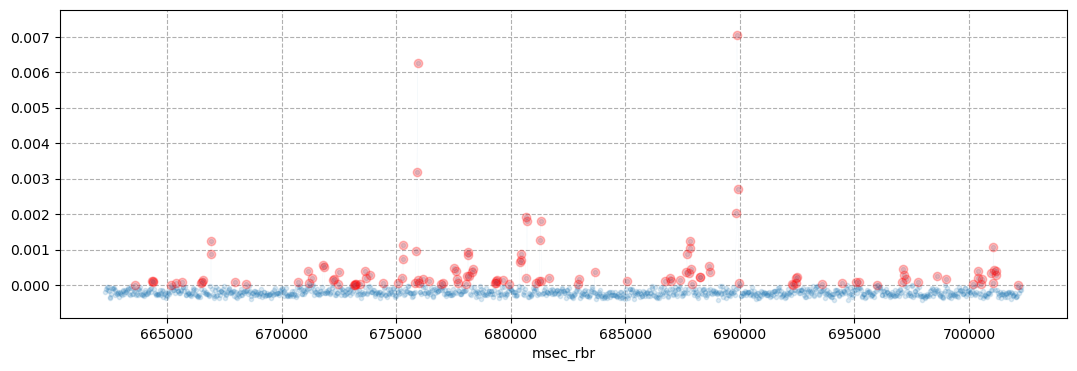

In [22]:
## Estimate spikes by removing median +/- minimum value

half_noise = np.median(rbr_smpl) - np.min(rbr_smpl)

rbr_spikes = rbr_smpl - np.median(rbr_smpl) - half_noise
rbr_log_spikes = np.log10(rbr_spikes)


fig, ax = plt.subplots()

rbr_spikes.plot(lw=0.1, marker='o', markersize=3, figsize=[13,4], ylim=[rbr_spikes.min() - 0.0005, np.percentile(rbr_spikes, 100)*1.1], alpha=0.15, ax=ax)

# ax.plot(rbr_spikes.index,  (np.median(rbr_smpl) ) * np.ones(rbr_spikes.index.size), 'r--')

rbr_spikes.loc[rbr_spikes >0].plot(lw=0, marker='o', markersize=6, c='r', ax=ax, alpha=0.25)

ax.grid(ls='--')

In [23]:
# extract percentiles
prct_pos = np.asarray([5, 16, 50, 84, 95, 100])
prct_vals = np.nanpercentile(rbr_log_spikes, prct_pos)


In [24]:
# define number of bins based on number of data points
bins = int(N/40)
print('number of bins ' + str(bins))


# extract spikes
y = rbr_log_spikes.values

# remove nans
y = y[~np.isnan(y)]

# compute how many spikes
N_spikes = len(y)

print('number of spikes ' + str(N_spikes))


number of bins 32
number of spikes 128


In [25]:
# get_distributions()

,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
norm,0.545278,99.384751,-688.982647,inf,0.032747,0.998489
burr12,0.553299,101.827024,-677.409496,inf,0.040449,0.979416
logistic,0.561352,101.417072,-685.263850,inf,0.042464,0.967576


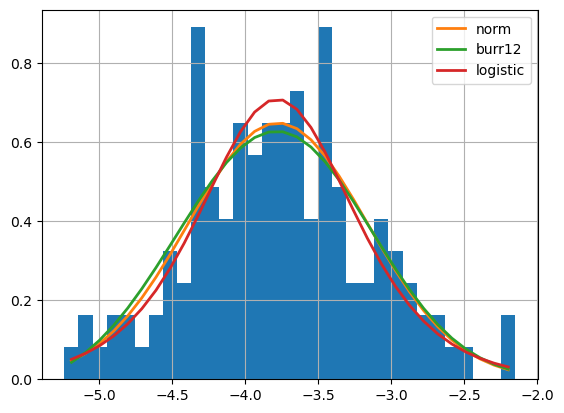

In [26]:
# fit distribution
from fitter import Fitter, get_common_distributions, get_distributions

f = Fitter(y,
           distributions=[
               'burr12',
               'norm',
               'logistic'
           ],
           bins=bins,
           density=False,
           # distributions=get_distributions(),
           # timeout=60
          )
f.fit()
f.summary()

In [29]:
f.fitted_param['burr12']

(3.423530340922837, 25.298948258436177, -5.648236277172953, 5.309534519428771)

In [30]:
f.fitted_param['norm']

(-3.7766156149554293, 0.6148365824695557)

In [31]:
f.fitted_param['logistic']

(-3.7821987514615762, 0.35262815371080747)

In [32]:
# c, d, loc, scale = f.fitted_param['burr12']
# [c, d, loc, scale]

In [33]:
loc, scale = f.fitted_param['logistic']
[loc, scale]

[-3.7821987514615762, 0.35262815371080747]

In [34]:
# Fitter?

In [35]:
def burr12_pdf(x, c, d, scale, loc):
    y = (x - loc) / scale
    out = c * d * y**(c - 1) / ((1 + y**c)**(d+1)) / scale
    return out

In [36]:
def burr12_cdf(x, c, d, scale, loc):
    y = (x - loc) / scale
    out = -(1 + y**c)**(-d)
    return out

In [37]:
def logistic_pdf(x, scale, loc):
    y = (x - loc) / scale
    out = np.exp(-y) / ( 1 + np.exp(-y)  )**2
    return out

In [38]:
def logistic_cdf(x, scale, loc):
    y = (x - loc) / scale
    out = - 1 / (np.exp(y) + 1)
    return out

In [40]:
## compute pdf and cdf from parameters

x = np.linspace(-6, -1, 400)

# pdf_burr12 = burr12_pdf(x, c, d, scale, loc)
# cdf_burr12 = burr12_cdf(x, c, d, scale, loc)
pdf_logistic = logistic_pdf(x, scale, loc)
cdf_logistic = logistic_cdf(x, scale, loc)



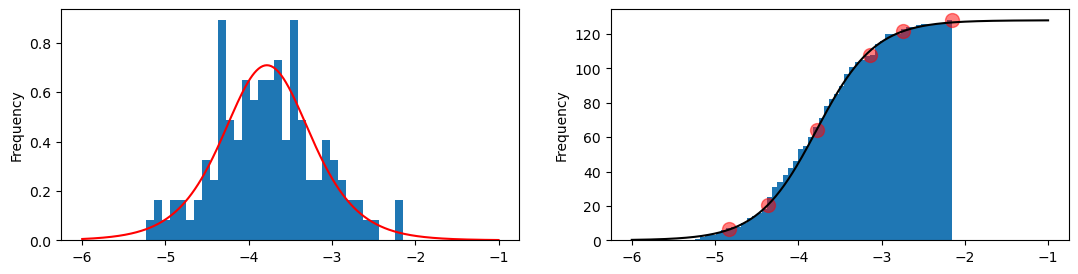

In [41]:
fig, ax = plt.subplots(1,2, figsize=[13,3])

rbr_log_spikes.plot.hist(bins=bins, 
                         density=True, 
                         ax=ax[0])

# density bool, default: False
# If True, draw and return a probability density: each bin will display the bin's raw count divided by 
# the total number of counts and the bin width (density = counts / (sum(counts) * np.diff(bins))), 
# so that the area under the histogram integrates to 1 (np.sum(density * np.diff(bins)) == 1).
# If stacked is also True, the sum of the histograms is normalized to 1.

ax[0].plot(x, pdf_logistic/scale, c='r') 
rbr_log_spikes.plot.hist(bins=50, cumulative=True, ax=ax[1])

ax[1].plot(prct_vals, prct_pos / 100 * N_spikes, 'ro-', ms=10, lw=0, alpha=.5)
ax[1].plot(x, (cdf_logistic + 1) * N_spikes , c='k') 

# TO DO

## - Bin the whole profile instead of just a random part (and plot baseline + spike distribution for each bin)
## - Do we need to optimize which percentiles we want?
## - Test on several profiles: 
## ----- What is the best type of distribution?
## ----- Do we need 5 percentiles or could we use less (and thus free-up space for CHL spikes)?
